In [392]:
library(dplyr)
library(plotrix)
library(caret) # createDataPartition
library(nnet)
library(e1071)
library(randomForest)
library(party)
options(warn = -1)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


In [6]:
train_df <- read.csv("../Data/Titanic_train.csv")
head(train_df, 10) 
tail(train_df)
str(train_df)

# 데이터가 어떤 식으로 되어있는지 잘못 입력된건 없는지 확인해야한다. 
## 항구 팩터가 4개 임으로 이상치가 하나 들어가있다 

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,382652,29.125,,Q
887,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.000,,S
888,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.000,B42,S
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NA,1,2,W./C. 6607,23.450,,S
890,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.000,C148,C
891,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.750,,Q


'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 354 273 16 555 516 625 413 577 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


### 컬럼 내용 확인 
- Survived : 생존 여부 (0 = 사망, 1 = 생존 True/False) / 이상치가 있는지 확인해봐야함 / Target컬럼 / 타켓이 숫자면 랜덤포레스트,SVM은 결과를 숫자로 준다
- Pclass : 티켓 등급  (1 = 1등급 객실, 2 = 2등급 , 3 = 3등급) / 타이타닉의 티켓 등급 확인 , 타이타닉의 구조 확인 (3등급은 출입구가 두 개밖에 없었다) 
    1등급은 작위가 있어야함 상류층, 2등급 작위는 없지만 돈은 많음 중산층, 3등급 서민 /  
    딥러닝에 쓸수 있는 정형데이터가 아직 별로 없다. 현재 이미지 같은 비정형데이터에 주로 사용
- SibSp : 함께 탑승한 형제, 자매, 배우자의 수
- Parch : 함께 탑승한 부모, 자식의 수 
- Fare : 운임, 짐에 대한 비용
- Cabin : 선실, 객실 번호
- Embarked : 탑승 항구 / 3곳 C = Chersbourg 오스트리아 (잘 살았음, 베토벤 시절) , Q = Queenstown 영국 , S = Southampton 영국 (영국은 못 살던 시절)

## 컬럼별로 하나씩 확인 작업

In [12]:
# 각 컬럼별 NA 확인
sum(is.na(train_df))
colSums(is.na(train_df))

# AGE에만 177개의 NA가 있다 
177 / 891 # 0.198653198653199 , 20% Age에 채워넣을 데이터, 연관된 데이터가 없다 

[1] 177

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

[1] 0.1986532

In [30]:
# train_df$Age가 NA인 것 빼고 데이터셋 만들기

head(subset(train_df , train_df$Age != 'NA'))
train_df_na <- subset(train_df , !is.na(Age))

## 갯수 확인하기
# 891 - 177 = 714
# nrow(subset(train_df , train_df$Age != 'NA')) = 714

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
7,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S


In [35]:
# Survived 기준으로 Dataset 정렬 
train_df <- arrange(train_df, train_df$Survived)
head(train_df)

# NA 없앤 버전
# arrange(train_df_na, train_df_na$Survived)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,,S


In [36]:
# 정렬된 크기 확인하기
dim(train_df) # 차원 확인하기 1. row , 2. col

[1] 891  12

## Target Column : Survived 분석 및 확인

In [71]:
# Survived의 생존과 사망 Count 확인 및 비율 계산하기
table(train_df$Survived)
count(train_df, train_df$Survived)

# 사망자수
nrow(train_df[train_df$Survived == 0 , ])
sum(train_df$Survived == 0)
# 생존자수
nrow(train_df[train_df$Survived == 1 , ])
sum(train_df$Survived == 1)
# 생존자수의 비율
nrow(train_df[train_df$Survived == 1 , ]) / nrow(train_df) * 100

# 피쳐는 특징이 있으면 좋고, 타겟은 비율이 고르면 좋다 (best 1:1이지만 거의 없음)



  0   1 
549 342 

train_df$Survived,n
0,549
1,342


[1] 549

[1] 549

[1] 342

[1] 342

[1] 38.38384

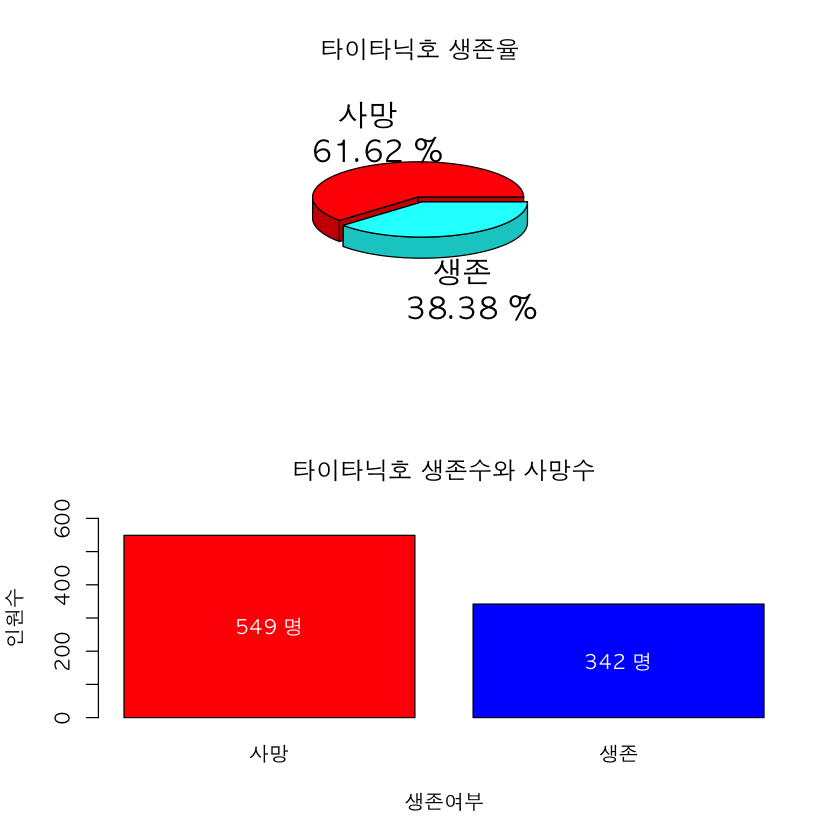

In [93]:
# 타이타닉호 생존율 시각화 

# 생존과 사망 비율을 Pie Chart로 생성 
Survive <- count(train_df, train_df$Survived)$n
ratio <- round(Survive / nrow(train_df) * 100 , 2)
label <- paste( c('사망','생존') , "\n", ratio , "%")


par(family = 'AppleGothic', bg = 'white' , mfrow = c(2,1)) # 
pie3D(Survive, 
    main = "타이타닉호 생존율",
    labels = label,
    col = rainbow(length(Survive)),
    explode = 0.05
)

# 생존자 수과 사망자 수 수치를 막대그래프로 생성
# 막대그래프 테이블이랑 친함 
par(family = 'AppleGothic', bg = 'white')
barplot(Survive , # table(train_df$Survived) 도 가능
    main = "타이타닉호 생존수와 사망수",
    ylab = "인원수",
    xlab = "생존여부",
    ylim = c(0,600),
    names = c('사망','생존'),
    col = c('red' , 'blue')
)
for(i in 1:length(Survive)) {
text(0.7 + (i-1)*1.2,Survive[i]/2,paste(Survive[i],'명'),col='white')
}

> Target Column으로 Survived를 선정

---
# Feature Column 찾기

In [92]:
head(train_df)
# 특징찾기 쉬운 컬럼 찾기
# -PassengerId- [Survived(Target)] Pclass -Name- !Sex! Age SibSp Parch -Ticket- Fare Cabin Embarked

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,,S


### 성별 Sex 컬럼 확인

In [96]:
# Sex 컬럼 분류 확인 
unique(train_df$Sex)
# 꼭 Levels를 확인하기

[1] male   female
Levels: female male

In [140]:
# 여성과 남성의 인원 확인 
count(train_df, train_df$Sex )
femaleCount <- sum(train_df$Sex == 'female')
maleCount <- sum(train_df$Sex == 'male')

# 여성의 생존수와 사망수
table(train_df$Sex , train_df$Survived)
femaleDeath <- sum(train_df$Sex == 'female' & train_df$Survived == 0) # 사망
femaleSurvive <- sum(train_df$Sex == 'female' & train_df$Survived == 1) # 생존
# subset(train_df , train_df$Sex == 'female' & train_df$Survived == 0 )

# 남성의 생존수와 사망수
maleDeath <- sum(train_df$Sex == 'male' & train_df$Survived == 0) # 사망
maleSurvive <- sum(train_df$Sex == 'male' & train_df$Survived == 1) # 생존

# 여성의 생존율과 사망율
table(train_df$Sex , train_df$Survived) / c(femaleCount,maleCount) * 100
cat('여성의 생존율 : ', round(femaleSurvive / femaleCount * 100 , 2) , '%\n' )
cat('여성의 사망율 : ', round(femaleDeath / femaleCount * 100 , 2) , '%\n' )

# 남성의 생존율과 사망율
cat('남성의 생존율 : ', round(maleSurvive / maleCount * 100 , 2) , '%\n' )
cat('남성의 사망율 : ', round(maleDeath / maleCount * 100 , 2) , '%\n' )


train_df$Sex,n
female,314
male,577


        
           0   1
  female  81 233
  male   468 109

        
                0        1
  female 25.79618 74.20382
  male   81.10919 18.89081

여성의 생존율 :  74.2 %
여성의 사망율 :  25.8 %
남성의 생존율 :  18.89 %
남성의 사망율 :  81.11 %


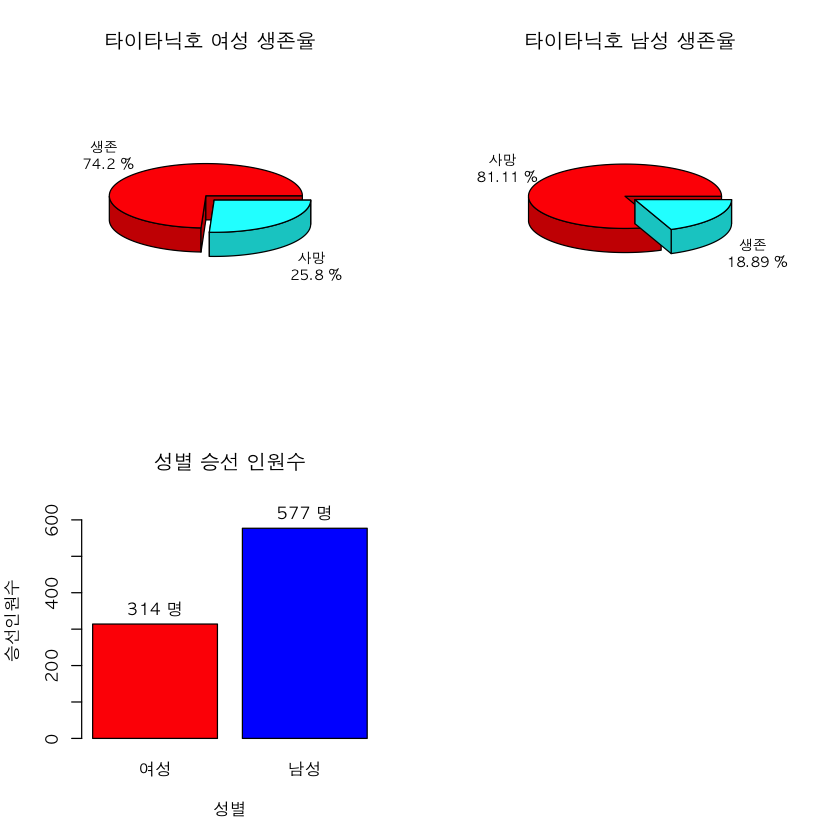

In [187]:
p <- table(train_df$Sex , train_df$Survived) / c(femaleCount,maleCount) * 100
c <- count(train_df, train_df$Sex )$n
femaleP <- p[1,]
maleP <- p[2,]

labelf <- paste( c('생존','사망') , "\n", round(femaleP[c(2,1)] ,2) , "%")
labelm <- paste( c('사망','생존') , "\n", round(maleP ,2) , "%")

par(family = 'AppleGothic', bg = 'white' ,mfrow=c(2,2)) # ,mfrow=c(2,2)
pie3D(femaleP[c(2,1)], 
    main = "타이타닉호 여성 생존율",
    labels = labelf,
    col = rainbow(length(femaleP)),
    explode = 0.05,
    labelcex = 0.7,
    radius=0.8
)
par(family = 'AppleGothic', bg = 'white' ) # 
pie3D(maleP, 
    main = "타이타닉호 남성 생존율",
    labels = labelm,
    col = rainbow(length(femaleP)),
    explode = 0.05,
    labelcex = 0.7,
    radius=0.8
)
bp <- barplot(
    c,
    main = '성별 승선 인원수',
    xlab = '성별',
    ylab = '승선인원수',
    ylim = c(0,650),
    col = c('red','blue'),
    names = c('여성','남성')
)
# for(i in 1:length(c)) {
# text(0.7 + (i-1)*1.2,c[i]+30,paste(c[i],'명')) #,col='orange'
# }
text(bp , c , paste(c , '명') , pos = 3)

> Sex 컬럼은 Feture로 적합하다
[Survived] <- [Sex]

In [ ]:
head(train_df)
# -PassengerId- [Survived(Target)] !Pclass! -Name- [Sex] Age SibSp Parch -Ticket- Fare Cabin Embarked

### 티켓 Pclass 등급 분석 

In [188]:
table(train_df$Pclass)


  1   2   3 
216 184 491 

1 등 객실의 여성 생존율은  91 / 94 명, 96.81 % 이다
2 등 객실의 여성 생존율은  70 / 76 명, 92.11 % 이다
3 등 객실의 여성 생존율은  72 / 144 명, 50 % 이다
-----------------------------------------------
1 등 객실의 남성 생존율은  45 / 122 명, 36.89 % 이다
2 등 객실의 남성 생존율은  17 / 108 명, 15.74 % 이다
3 등 객실의 남성 생존율은  47 / 347 명, 13.54 % 이다
-----------------------------------------------


[1] 96.81 92.11 50.00 36.89 15.74 13.54

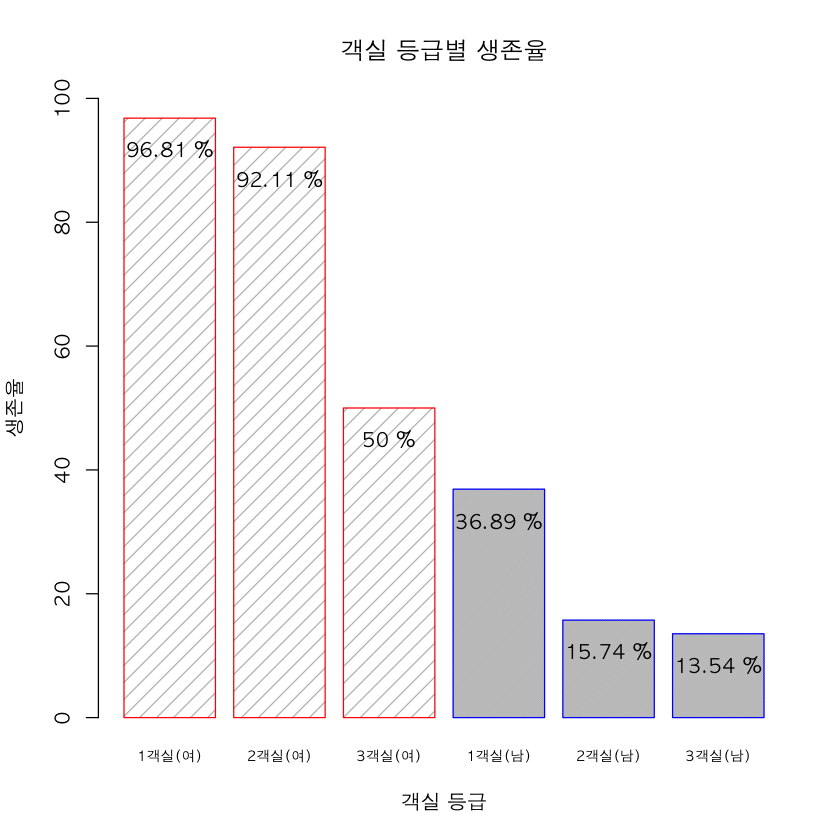

In [265]:
# 1등 객실의 여성 생존율 
tot1f <-sum(train_df$Sex == 'female' & train_df$Pclass == 1)
sur1f <-sum(train_df$Sex == 'female' & train_df$Pclass == 1 & train_df$Survived == 1)
# sum(train_df$Sex == 'female' & train_df$Pclass == 1 & train_df$Survived == 1) / sum(train_df$Sex == 'female' & train_df$Pclass == 1) * 100

# cat( '1등 객실의 여성 생존율은 ' , sur1f,'/',tot1f,'명,', round(sur1f/tot1f*100,2) ,'% 이다')

# subset(train_df ,train_df$Sex == 'female' & train_df$Pclass == 1)

pclassV <- c()

for(j in c('female','male')){
    for(i in 1:3){
        tot <- sum(train_df$Sex == j & train_df$Pclass == i)
        sur <- sum(train_df$Sex == j & train_df$Pclass == i & train_df$Survived == 1)
        pp <- round(sum(train_df$Sex == j & train_df$Pclass == i & train_df$Survived == 1) / sum(train_df$Sex == j & train_df$Pclass == i) * 100,2)
        cat( i ,'등 객실의' , ifelse(j == 'male','남성','여성'), '생존율은 ' ,sur ,'/', tot,'명,', pp ,'% 이다\n')
        pclassV <- append(pclassV , pp)
    }
    cat('-----------------------------------------------\n')
}

# 여성 1,2등급이 비슷 / 남성 2,3등급이 비슷 

# 막대그래프 
pclassV
label <- c('1객실(여)','2객실(여)','3객실(여)','1객실(남)','2객실(남)','3객실(남)')
par(family = 'AppleGothic', bg = 'white')
bp <- barplot( pclassV,
    names = label,
    main = '객실 등급별 생존율',
    xlab = '객실 등급',
    ylab = '생존율',
    ylim = c(0,100),
    border = c(rep('red',3),rep('blue',3)),
    density = c(rep(10,3),rep(100,3)),
    cex.names = 0.7
    
)
# text(bp, pclassV , paste( pclassV , '%') , pos=1)

for(i in 1:length(pclassV)) {
 text(0.7 + (i-1)*1.2, pclassV[i]-5 , paste(pclassV[i],'%')) 
}

> [Survived] <- [Sex, Pclass]
> 컬럼 최소 한개만 더하면 머신러닝을 돌릴 수 있다!

In [266]:
head(train_df)
# -PassengerId- [Survived(Target)] [Pclass] -Name- [Sex] Age SibSp Parch -Ticket- Fare Cabin !Embarked!

# Embarked는 이상치가 있는 컬럼이라 데이터 수정을 해줘야 한다

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,,S


In [277]:
## 최대 운임 찾기 ,  그냥 하는거임
subset(train_df, train_df$Fare == max(train_df$Fare)) # 최대 운임
mean(train_df$Fare) # 평균 운임 / 최대 운임비는 평균운임비의 10배 보다 높다

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
639,259,1,1,"Ward, Miss. Anna",female,35,0,0,PC 17755,512.3292,,C
814,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36,0,1,PC 17755,512.3292,B51 B53 B55,C
836,738,1,1,"Lesurer, Mr. Gustave J",male,35,0,0,PC 17755,512.3292,B101,C


[1] 32.20421

In [280]:
table(train_df$Embarked)
unique(train_df$Embarked) # Levels 확인

# 빈칸의 데이터 찾기
subset(train_df, train_df$Embarked =='')

# 항구별 탑승 인원을 구하여 가장 많은 탑승인원의 항구로 결정 
# S 항구 탑승인원
sum(train_df$Embarked == 'S')
# C 항구 탑승인원
sum(train_df$Embarked == 'C')
# Q 항구 탑승인원
sum(train_df$Embarked == 'Q')
# 600명 이상이 S항구에서 탑승했으니 빈값 항구를 S항구로 변경해도 무방하다고 판단


      C   Q   S 
  2 168  77 644 

[1] S Q C  
Levels:  C Q S

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
577,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
868,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,


[1] 644

[1] 168

[1] 77

> 빈값 항구를 S항구로 변경

In [291]:
# 연습을 위한 데이터셋 복제
train_df_T <- train_df

# 빈값 항구 찾기 _ 1
subset(train_df_T, train_df_T$Embarked =='')

# 빈값 항구 찾기 _ 2
train_df_T[train_df_T$Embarked=="",] # 파이썬 방식

# 빈칸 항구를 S 항구로 변경 - 1
train_df_T$Embarked <- ifelse(train_df_T$Embarked=='','S',train_df_T$Embarked)
train_df_T[train_df_T$Embarked=="",] # 빈칸 값 없는 것 확인

# 빈칸 항구를 S 항구로 변경 - 2
train_df_T <- train_df # 빈값 복구
train_df_T[train_df_T$Embarked == '',]$Embarked <- "S"
train_df_T[train_df_T$Embarked=="",] # 빈칸 값 없는 것 확인

# 빈칸 항구를 S 항구로 변경 - 3
train_df_T <- train_df # 빈값 복구
train_df_T$Embarked[train_df_T$Embarked == ''] <- "S"
train_df_T[train_df_T$Embarked=="",] # 빈칸 값 없는 것 확인




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
577,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
868,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
577,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,
868,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [295]:
# 본 데이터에 적용
train_df$Embarked[train_df$Embarked == ''] <- "S"
# S 항구 탑승인원
sum(train_df$Embarked == 'S')
# str(train_df)

# factor 정리
train_df$Embarked <- factor(train_df$Embarked)
str(train_df)


[1] 646

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 5 6 7 8 13 14 15 17 19 ...
 $ Survived   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pclass     : int  3 3 3 1 3 3 3 3 3 3 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 16 555 516 625 730 29 841 683 840 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 2 2 2 2 2 2 1 2 1 ...
 $ Age        : num  22 35 NA 54 2 20 39 14 2 31 ...
 $ SibSp      : int  1 0 0 0 3 0 1 0 4 1 ...
 $ Parch      : int  0 0 0 0 1 0 5 0 1 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 473 276 86 396 536 334 414 481 302 ...
 $ Fare       : num  7.25 8.05 8.46 51.86 21.07 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 1 1 131 1 1 1 1 1 1 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 3 2 3 3 3 3 3 2 3 ...


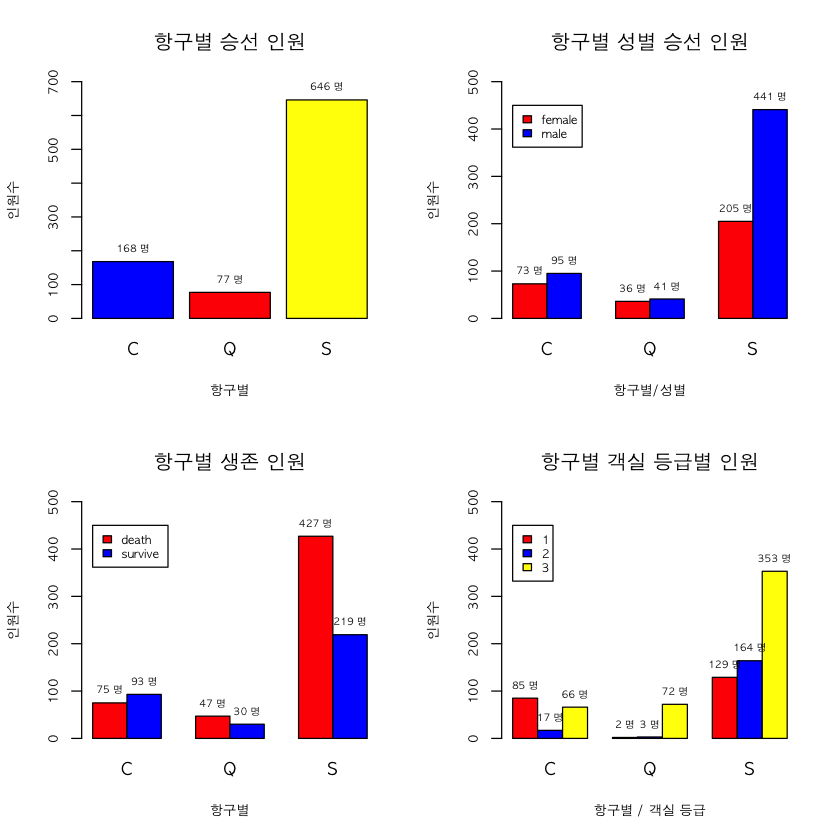

In [349]:
# 항구별 승선 인원
par(family = 'AppleGothic', bg = 'white' ,mfrow =c(2,2))
bp <- barplot(table(train_df$Embarked),
    main = '항구별 승선 인원',
    xlab= '항구별',
    ylab= '인원수',
    ylim= c(0,700),
    col = c('blue', 'red','yellow'),
    cex.axis=0.75,
    cex.lab = 0.8,

)
text(bp , table(train_df$Embarked), paste(table(train_df$Embarked),'명'), pos=3 ,cex=0.6)

# 항구별 승선 인원 성별 분류
par(family = 'AppleGothic', bg = 'white')
bp<-barplot(table(train_df$Sex ,train_df$Embarked),
    main = '항구별 성별 승선 인원',
    xlab= '항구별/성별',
    ylab= '인원수',
    ylim= c(0,500),
    col = c('red' , 'blue'),
    beside =T,
    cex.axis=0.75,
    cex.lab = 0.8,

)
legend(1,450,
    legend = rownames(table(train_df$Sex ,train_df$Embarked)),
    fill = c('red' , 'blue'),
    cex = 0.7
)
text(bp ,table(train_df$Sex ,train_df$Embarked),paste(table(train_df$Sex ,train_df$Embarked),'명'),pos=3 ,cex=0.6 )

# 항구별 생존 인원 
par(family = 'AppleGothic', bg = 'white')
bp<-barplot(table(train_df$Survived ,train_df$Embarked),
    main = '항구별 생존 인원',
    xlab= '항구별',
    ylab= '인원수',
    ylim= c(0,500),
    col = c('red' , 'blue'),
    beside =T,
    cex.axis=0.75,
    cex.lab = 0.8,

)
legend(1,450,
    legend = c('death','survive'),
    fill = c('red' , 'blue'),
    cex = 0.7
)
text(bp ,table(train_df$Survived ,train_df$Embarked),paste(table(train_df$Survived ,train_df$Embarked),'명'),pos=3 ,cex=0.6)

# 항구별 객실 등급별 인원
par(family = 'AppleGothic', bg = 'white')
bp<-barplot(table(train_df$Pclass ,train_df$Embarked),
    main = '항구별 객실 등급별 인원',
    xlab= '항구별 / 객실 등급',
    ylab= '인원수',
    ylim= c(0,500),
    col = c('red' , 'blue','yellow'),
    beside =T,
    cex.axis=0.75,
    cex.lab = 0.8,

)
legend(1,450,
    legend = rownames(table(train_df$Pclass ,train_df$Embarked)),
    fill = c('red' , 'blue','yellow'),
    cex = 0.7
)
text(bp ,table(train_df$Pclass ,train_df$Embarked),paste(table(train_df$Pclass ,train_df$Embarked),'명'),pos=3 ,cex=0.6)

> [Survived] <- [Sex, Pclass,Embarked]

# 곤듀님 왔다감 ^_^* 

## RandomForest로 예측모델 생성

In [363]:
# 복사본
train_df_T <- train_df

In [364]:
# 예측을 위한 컬럼 확인
target_col <- c("Survived" , 'Sex','Pclass','Embarked')
head(train_df_T[,target_col])

Survived,Sex,Pclass,Embarked
0,male,3,S
0,male,3,S
0,male,3,Q
0,male,1,S
0,male,3,S
0,male,3,S


In [365]:
# Sex 컬럼을 숫자로 전환
train_df_T$SexCode[train_df_T$Sex == "male"] <- 0
train_df_T$SexCode[train_df_T$Sex == "female"] <- 1

head(train_df_T,10)

# Sex 컬럼 삭제
train_df_T <- subset(train_df_T , select = -Sex)
head(train_df_T)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexCode
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S,0
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S,0
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q,0
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,0
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S,0
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,,S,0
14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.2750,,S,0
15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14,0,0,350406,7.8542,,S,1
17,0,3,"Rice, Master. Eugene",male,2,4,1,382652,29.1250,,Q,0
19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)",female,31,1,0,345763,18.0000,,S,1


PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexCode
1,0,3,"Braund, Mr. Owen Harris",22,1,0,A/5 21171,7.2500,,S,0
5,0,3,"Allen, Mr. William Henry",35,0,0,373450,8.0500,,S,0
6,0,3,"Moran, Mr. James",NA,0,0,330877,8.4583,,Q,0
7,0,1,"McCarthy, Mr. Timothy J",54,0,0,17463,51.8625,E46,S,0
8,0,3,"Palsson, Master. Gosta Leonard",2,3,1,349909,21.0750,,S,0
13,0,3,"Saundercock, Mr. William Henry",20,0,0,A/5. 2151,8.0500,,S,0


In [366]:
# 타겟코드 다시 정리
target_col <- c("Survived" , 'SexCode','Pclass','Embarked')
head(train_df_T[,target_col])

Survived,SexCode,Pclass,Embarked
0,0,3,S
0,0,3,S
0,0,3,Q
0,0,1,S
0,0,3,S
0,0,3,S


### Embarked를 숫자로 전환
C = 0, S = 1 , Q = 2 -> 맞긴 맞지만 좋은 생각이 아니다.
2 * S = Q , S + S = Q -> 이런 오류가 생긴다 

### One-Hot Encoding 방법
C == [1,0,0]
S == [0,1,0]
Q == [0,0,1]
처럼 행렬로 만들면 덧셈과 뺄셈에 때에 각각 계산이 굉장히 안전해 진다.
R은 내부적으로 1은 TRUE , 0은 False로 인식한다.

In [367]:
train_df_T$Embarked_C = train_df_T$Embarked == "C" 
train_df_T$Embarked_S = train_df_T$Embarked == "S" 
train_df_T$Embarked_Q = train_df_T$Embarked == "Q" 

head(train_df_T[c('Embarked','Embarked_C','Embarked_S','Embarked_Q')])

Embarked,Embarked_C,Embarked_S,Embarked_Q
S,FALSE,TRUE,FALSE
S,FALSE,TRUE,FALSE
Q,FALSE,FALSE,TRUE
S,FALSE,TRUE,FALSE
S,FALSE,TRUE,FALSE
S,FALSE,TRUE,FALSE


In [370]:
# 타겟코드 다시 정리
target_col <- c("Survived" , 'SexCode','Pclass','Embarked_C','Embarked_S','Embarked_Q')
head(train_df_T[,target_col])

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q
0,0,3,FALSE,TRUE,FALSE
0,0,3,FALSE,TRUE,FALSE
0,0,3,FALSE,FALSE,TRUE
0,0,1,FALSE,TRUE,FALSE
0,0,3,FALSE,TRUE,FALSE
0,0,3,FALSE,TRUE,FALSE


In [372]:
# 데이터셋 새로 만들기
train_data <- train_df_T[,target_col]
head(train_data)
str(train_data)

Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q
0,0,3,FALSE,TRUE,FALSE
0,0,3,FALSE,TRUE,FALSE
0,0,3,FALSE,FALSE,TRUE
0,0,1,FALSE,TRUE,FALSE
0,0,3,FALSE,TRUE,FALSE
0,0,3,FALSE,TRUE,FALSE


'data.frame':	891 obs. of  6 variables:
 $ Survived  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SexCode   : num  0 0 0 0 0 0 0 1 0 1 ...
 $ Pclass    : int  3 3 3 1 3 3 3 3 3 3 ...
 $ Embarked_C: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Embarked_S: logi  TRUE TRUE FALSE TRUE TRUE TRUE ...
 $ Embarked_Q: logi  FALSE FALSE TRUE FALSE FALSE FALSE ...


In [437]:
# Sampling
set.seed(1234)
samp <- createDataPartition(train_data$Survived, p=0.7, list=F)
# 학습용
data.train <- train_data[samp,]
# 검증용
data.test <- train_data[-samp,]

# 문제 및 정답 만들기
x <- subset(data.test, select = -Survived)
y <- data.test$Survived


In [438]:
# 랜덤포레스트
# 학습시키기 
model.rf <- randomForest(Survived ~ . , data = data.train , ntree = 100 )

# 검증하기 
pred <- predict(model.rf , x)

# 예측력과 오분류포
mean(pred == y)
table(pred , y) 
## Survived가 int값으로 들어가 있기 때문에 예측을 0,1로 하는게 아니라 주관식으로 계산해서 0.22,0.58 등 계산 값을 예측해버린다.
## (파이썬?) sigmoid 함수를 사용해야 한다. 0하고1사이의 값만 내놓는다. 0.5 기준으로 0 , 1 로 판단한다

# 해결방법 1 ) 우리가 조건울 주어서 2지선다로 바꾼것
pred[pred <= 0.5] <- 0
pred[pred > 0.5] <- 1
head(pred)
mean(pred == y)
table(pred , y) 


[1] 0

                   y
pred                 0  1
  0.229457161251172 77 12
  0.273039175700199 12  2
  0.293434856171774 22  6
  0.32865970146674  15  8
  0.348585074712486  8  2
  0.400756676858172  1  0
  0.413781356739698 15 14
  0.438782097650849  6  5
  0.56865773494729   4  6
  0.580887127781153  2 15
  0.593013969495393  0 15
  0.618187873616651  3  6
  0.729800516458406  0  1
  0.741100163580865  1  9

5  6  7  8  9 16 
 0  0  0  0  0  0

[1] 0.7790262

    y
pred   0   1
   0 156  49
   1  10  52

--- 
### Survived를 factor로 변환 후에 randomForest 실행

In [439]:
data.train$Survived <- as.factor(data.train$Survived)
data.test$Survived <- as.factor(data.test$Survived)
# 학습시키기 
model.rf <- randomForest(Survived ~ . , data = data.train , ntree = 100 )
# 문제 및 정답 만들기
x <- subset(data.test, select = -Survived)
y <- data.test$Survived
# 검증하기 
pred <- predict(model.rf , x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y) # 사망자는 잘 맞추지만 생존자는 반밖에 못맞춘다


[1] 0.7790262

    y
pred   0   1
   0 156  49
   1  10  52

## 인공신경망, 의사결정나무, 랜덤포레스트, SVM, 로지스틱 으로 분석해보기

In [668]:

# 인공신경망
model.nnet <- nnet(Survived ~ . , data=data.train, size = 3)
# 검증
pred <- predict(model.nnet, x, type='class')
# 예측력과 오분류포
mean(pred == y)
table(pred , y)

# 의사결정나무
model.ctree <- ctree(Survived ~ . , data=data.train )
# 검증
pred <- predict(model.ctree, x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y)

# SVM
model.svm = svm(Survived ~ . , data=data.train )
# 검증
pred <- predict(model.svm, x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y)

# 로지스틱
model.mt <- multinom(Survived ~ . , data=data.train )
# 검증하기
pred <- predict(model.mt , x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y) + as.table(matrix(nrow=2,ncol=2))

# weights:  28
initial  value 448.106235 
iter  10 value 245.657865
iter  20 value 216.453537
iter  30 value 212.662010
iter  40 value 211.854763
iter  50 value 210.005079
iter  60 value 209.647383
iter  70 value 206.594890
iter  80 value 205.776304
iter  90 value 205.366176
iter 100 value 205.236318
final  value 205.236318 
stopped after 100 iterations


[1] 0.8224299

    y
pred   0   1
   0 126  37
   1   1  50

[1] 0.8037383

    y
pred   0   1
   0 120  35
   1   7  52

[1] 0.7850467

    y
pred   0   1
   0 101  20
   1  26  67

# weights:  9 (8 variable)
initial  value 346.573590 
iter  10 value 227.455480
final  value 227.434646 
converged


[1] 0.771028

    y
pred 0 1
   0    
   1    

In [1017]:
train_df_na <- subset(train_df , !is.na(Age))

# Sex 컬럼을 숫자로 전환
train_df_na$SexCode[train_df_na$Sex == "male"] <- 0
train_df_na$SexCode[train_df_na$Sex == "female"] <- 1
# 필요없는 컬럼 삭제
train_df_na <- train_df_na[,-c(1,5,9,11)]

train_df_na$Embarked_C = train_df_na$Embarked == "C" 
train_df_na$Embarked_S = train_df_na$Embarked == "S" 
train_df_na$Embarked_Q = train_df_na$Embarked == "Q" 
# 어린이 기준
train_df_na$Age_c = train_df_na$Age < 16
train_df_na$Age_a = train_df_na$Age >= 16

# 운임비 평균 기준 
# 평균보다 낮다 2/3가 사망, 평균보다 높다 2/3이 생존
# summary(train_df_na$Fare)
# table(train_df_na[train_df_na$Fare<=34.69,]$Survived)
# table(train_df_na[train_df_na$Fare>34.69,]$Survived)
# 컬럼 추가
train_df_na$Fare_r = train_df_na$Fare<=34.69
train_df_na$Fare_h = train_df_na$Fare>34.69

# 가족과 함께 / 혼자
# table(train_df_na[train_df_na$Parch == 0 & train_df_na$SibSp == 0,]$Survived)
# table(train_df_na[train_df_na$Parch != 0 | train_df_na$SibSp != 0,]$Survived)
train_df_na$isAlone = train_df_na$Parch == 0 & train_df_na$SibSp == 0
train_df_na$notAlone = train_df_na$Parch != 0 | train_df_na$SibSp != 0

# 등급별 여성과 어린이(중학생이하)
train_df_na$chp1 = train_df_na$Age<16 & train_df_na$Pclass == 1
train_df_na$chp2 = train_df_na$Age<16 & train_df_na$Pclass == 2
train_df_na$chp3 = train_df_na$Age<16 & train_df_na$Pclass == 3
train_df_na$fep1 = train_df_na$SexCode==1 & train_df_na$Pclass == 1
train_df_na$fep2 = train_df_na$SexCode==1 & train_df_na$Pclass == 2
train_df_na$fep3 = train_df_na$SexCode==1 & train_df_na$Pclass == 3

# 국적 (출항지 기준 영국/C)
train_df_na$nationE = train_df_na$Embarked == 'S' | train_df_na$Embarked == 'Q'
train_df_na$nationF = train_df_na$Embarked == 'C'


# 국적 , 나이대 , 운임비? , 

# 타겟코드 
target_col <- c("Survived" , 'SexCode','Pclass','Embarked_C','Embarked_S','Embarked_Q' ,'Age_c','Age_a', 'Fare_r','Fare_h','isAlone','notAlone',
    'chp1','chp2','chp3','fep1','fep2','fep3','nationE','nationF') #

# 데이터셋 새로 만들기
train_data <- train_df_na[,target_col]
train_data$Survived <- as.factor(train_data$Survived)
head(train_data)
# str(train_data)

table(train_df_na$Survived) # 0 424 / 1  290 
nrow(train_df_na) # 714
#head(train_df_na)

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,Age_c,Age_a,Fare_r,Fare_h,isAlone,notAlone,chp1,chp2,chp3,fep1,fep2,fep3,nationE,nationF
1,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
2,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
4,0,0,1,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
5,0,0,3,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
6,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
7,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE



  0   1 
424 290 

[1] 714

In [932]:
# summary(train_df_na$Age)
# table(train_df_na[train_df_na$Age<16 & train_df_na$Pclass == 1 ,]$Survived)
# table(train_df_na[train_df_na$Age<16 & train_df_na$Pclass == 2 ,]$Survived)
# table(train_df_na[train_df_na$Age<16 & train_df_na$Pclass == 3 ,]$Survived)
# table(train_df_na[train_df_na$SexCode==1 & train_df_na$Pclass == 1 ,]$Survived)
# table(train_df_na[train_df_na$SexCode==1 & train_df_na$Pclass == 2 ,]$Survived)
# table(train_df_na[train_df_na$SexCode==1 & train_df_na$Pclass == 3 ,]$Survived)
table(train_df_na[train_df_na$Age<16,]$Survived)

table(train_df_na[train_df_na$Embarked == 'S' | train_df_na$Embarked == 'Q',]$Survived)
table(train_df_na[train_df_na$Embarked == 'C',]$Survived)



 0  1 
34 49 


  0   1 
373 211 


 0  1 
51 79 

In [618]:
424/714 * 100
290/714 * 100

[1] 59.38375

[1] 40.61625

In [970]:
# Sampling
set.seed(1234)
samp <- createDataPartition(train_data$Survived, p=0.7, list=F)

# 학습용
data.train <- train_data[samp,]
# 검증용
data.test <- train_data[-samp,]

# 문제 및 정답 만들기
x <- subset(data.test, select = -Survived)
y <- data.test$Survived


In [610]:
# set.seed(1234)
# samp <- c(sample(1:424, 300) , sample(425:714, 250))

# # 학습용
# data.train <- train_data[samp,]
# # 검증용
# data.test <- train_data[-samp,]

# # 문제 및 정답 만들기
# x <- subset(data.test, select = -Survived)
# y <- data.test$Survived

[1] 0.7075472

[1] 0.862069

In [981]:
# 랜덤포레스트
# 학습시키기 
model.rf <- randomForest(Survived ~ . , data = data.train , ntree = 100 )
# 검증하기 
pred <- predict(model.rf , x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y) 

# 인공신경망
model.nnet <- nnet(Survived ~ . , data=data.train, size = 3)
# 검증
pred <- predict(model.nnet, x, type='class')
# 예측력과 오분류포
mean(pred == y)
table(pred , y)

# 의사결정나무
model.ctree <- ctree(Survived ~ . , data=data.train )
# 검증
pred <- predict(model.ctree, x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y)

# SVM
model.svm = svm(Survived ~ . , data=data.train )
# 검증
pred <- predict(model.svm, x)
# 예측력과 오분류포
mean(pred == y)
table(pred , y)

# 로지스틱
model.mt <- multinom(Survived ~ . , data=data.train )
# 검증하기
pred <- predict(model.mt , x)
# 예측력과 오분류포
mean(pred == y)
as.matrix(table(pred , y)) 

[1] 0.8224299

    y
pred   0   1
   0 116  27
   1  11  60

# weights:  64
initial  value 325.120907 
iter  10 value 208.239066
iter  20 value 199.303836
iter  30 value 195.613202
iter  40 value 194.851635
iter  50 value 194.656570
iter  60 value 194.606412
iter  70 value 194.593019
iter  80 value 194.589138
iter  90 value 194.588879
iter 100 value 194.588762
final  value 194.588762 
stopped after 100 iterations


[1] 0.8037383

    y
pred   0   1
   0 113  28
   1  14  59

[1] 0.8130841

    y
pred   0   1
   0 126  39
   1   1  48

[1] 0.8037383

    y
pred   0   1
   0 112  27
   1  15  60

# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged


[1] 0.8224299

    y
pred   0   1
   0 119  30
   1   8  57


1) set.seed(1234)
2) 5번 평균값으로 쓴다 
3) 

In [1004]:
인공신경망 <- function(data){

  model <- nnet(Survived ~ . , data=data.train, size = 3)

  rtn = 0
  
  for(i in 1:5){
    pred <- predict(model, x, type = "class")
    rtn <- rtn + mean(pred == y)
    table(pred,y) 
  }

  rtn <- round(rtn / 5 , 8)
  
  return(rtn)
}

In [1005]:
의사결정나무 <- function(data){

  model <- ctree(Survived ~ . , data = data.train)

  rtn = 0

  for(i in 1:5){
    pred <- predict(model, x)
    rtn <- rtn + mean(pred == y)
  }

  rtn <- round(rtn / 5,8)

  return(rtn)
}

In [1006]:
RF <- function(data){

  model <- randomForest(Survived ~ . , data = data.train, ntree = 100)

  rtn = 0

  for(i in 1:5){
    pred <- predict(model, x)
    rtn <- rtn + mean(pred == y)
  }

  rtn <- round(rtn / 5,8)
  
  return(rtn)
}

In [1007]:
SVM <- function(data){

  model <- svm(Survived ~ . , data=data.train)

  rtn = 0

  for(i in 1:5){
    pred <- predict(model, x)
    rtn <- rtn + mean(pred == y)
  }

  rtn <- round(rtn / 5,8)

  return(rtn)
}

In [1008]:
다항로지스틱 <- function(data){

  model <- multinom(Survived ~ . , data=data.train)


  rtn = 0

  for(i in 1:5){
    pred <- predict(model, x)
    rtn <- rtn + mean(pred == y)
  }

  rtn <- round(rtn / 5,8)
  
  return(rtn)
}

In [1009]:
head(train_data)
set.seed(1234)
samp <- createDataPartition(train_data$Survived, p=0.7, list=F)
  # 학습용
  data.train <- train_data[samp,]
  # 검증용
  data.test <- train_data[-samp,]

  # 문제 및 정답 만들기
  x <- subset(data.test, select = -Survived)
  y <- data.test$Survived

,Survived,SexCode,Pclass,Embarked_C,Embarked_S,Embarked_Q,Age_c,Age_a,Fare_r,Fare_h,isAlone,notAlone,chp1,chp2,chp3,fep1,fep2,fep3,nationE,nationF
1,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
2,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
4,0,0,1,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
5,0,0,3,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
6,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
7,0,0,3,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE


In [1016]:
예측력 <- c(인공신경망(train_data), 의사결정나무(train_data), RF(train_data), SVM(train_data), 다항로지스틱(train_data))
result <- data.frame(예측력)
rownames(result) = c('인공신경망', '의사결정나무', 'RandomForest', 'SVM', '로지스틱회귀분석')

result

# weights:  64
initial  value 409.644150 
iter  10 value 215.775754
iter  20 value 202.923021
iter  30 value 199.769758
iter  40 value 198.649262
iter  50 value 197.597494
iter  60 value 197.427502
iter  70 value 197.400611
iter  80 value 197.398668
final  value 197.398643 
converged
# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged


,예측력
인공신경망,0.8037383
의사결정나무,0.8130841
RandomForest,0.8037383
SVM,0.8037383
로지스틱회귀분석,0.8224299


In [984]:
matrix(nrow=2,ncol=2 ,0)

0,0
0,0


### 오분류표 평균 구하기 어렵당

In [998]:
인공신경망t <- function(data){
  rtn = matrix(nrow=2,ncol=2,0)
  
  for(i in 1:5){
    model <- nnet(Survived ~ . , data=data.train, size = 3)
    pred <- predict(model, x, type = "class")
    rtn <- rtn + as.matrix(table(pred,y))
  }

  rtn <- rtn /5
  
  return(rtn)
}

In [999]:
의사결정나무t <- function(data){
  rtn = matrix(nrow=2,ncol=2,0)

  for(i in 1:5){
    model <- ctree(Survived ~ . , data = data.train)
    pred <- predict(model, x)
    rtn <- rtn + as.matrix(table(pred,y))
  }

  rtn <- rtn / 5

  return(rtn)
}

In [1000]:
RFt <- function(data){
  rtn = matrix(nrow=2,ncol=2,0)

  for(i in 1:5){
    model <- randomForest(Survived ~ . , data = data.train, ntree = 100)
    pred <- predict(model, x)
    rtn <- rtn + as.matrix(table(pred,y))
  }

  rtn <- rtn / 5
  
  return(rtn)
}

In [1001]:
SVMt <- function(data){

  rtn = matrix(nrow=2,ncol=2,0)

  for(i in 1:5){
    model <- svm(Survived ~ . , data=data.train)
    pred <- predict(model, x)
    rtn <- rtn + as.matrix(table(pred,y))
  }

  rtn <- rtn / 5

  return(rtn)
}

In [1002]:
다항로지스틱t <- function(data){

  rtn = matrix(nrow=2,ncol=2,0)

  for(i in 1:5){
    model <- multinom(Survived ~ . , data=data.train)
    pred <- predict(model, x)
    rtn <- rtn + as.matrix(table(pred,y))
  }

  rtn <- rtn / 5
  
  return(rtn)
}

In [1003]:
인공신경망t(train_data)
의사결정나무t(train_data)
RFt(train_data)
SVMt(train_data) 
다항로지스틱t(train_data)


# weights:  64
initial  value 348.502894 
iter  10 value 223.838980
iter  20 value 207.690247
iter  30 value 201.336815
iter  40 value 198.746665
iter  50 value 198.345334
iter  60 value 198.234013
iter  70 value 198.146086
iter  80 value 198.111532
iter  90 value 198.079487
iter 100 value 198.061267
final  value 198.061267 
stopped after 100 iterations
# weights:  64
initial  value 343.414156 
iter  10 value 217.193837
iter  20 value 200.674111
iter  30 value 197.063044
iter  40 value 195.904180
iter  50 value 195.556556
iter  60 value 195.494928
iter  70 value 195.491880
iter  80 value 195.480597
iter  90 value 195.478842
iter 100 value 195.477774
final  value 195.477774 
stopped after 100 iterations
# weights:  64
initial  value 344.141440 
iter  10 value 244.932038
iter  20 value 205.217959
iter  30 value 200.337105
iter  40 value 199.052851
iter  50 value 198.717549
iter  60 value 198.466215
iter  70 value 198.406702
iter  80 value 198.350300
iter  90 value 198.337008
iter 100 val

    y
pred     0     1
   0 109.2  25.4
   1  17.8  61.6

    y
pred   0   1
   0 126  39
   1   1  48

    y
pred     0     1
   0 115.8  28.0
   1  11.2  59.0

    y
pred   0   1
   0 112  27
   1  15  60

# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged
# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged
# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged
# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged
# weights:  21 (20 variable)
initial  value 346.573590 
iter  10 value 220.586630
iter  20 value 210.104525
iter  30 value 210.094230
final  value 210.094104 
converged


    y
pred   0   1
   0 119  30
   1   8  57